In [16]:
import logging
from typing import Any, Dict, Optional

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin

import dataflow.core as dtfcore
import dataflow.core.node as dtfcornode
import dataflow.core.nodes.sklearn_models as dtfcnoskmo
import dataflow.core.nodes.sources as dtfconosou
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import research_amp.soccer_prediction.preproccesing as rasoprpr
import research_amp.soccer_prediction.utils as rasoprut
import research_amp.soccer_prediction.models as rasoprmo

In [ ]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

In [18]:
def preprocess_data(df: pd.DataFrame()) -> pd.DataFrame():
    """
    Preprocess the loaded ISDB dataframe of interest.

        - Filter and select match from seasons starting from 2009.
        - Convert column formats.
        - Add epsilon = 0.5 to scores with value as `0` to avoid log(0).
        - Check for NaN and infinite values and drop the rows.

    :param df: Input DataFrame.
    :return: Preprocessed DataFrame.
    """
    df["season"] = df["Sea"].apply(lambda x: int("20" + str(x)[:2]))
    filtered_df = df[df["season"] >= 2009]
    # Preprocess the dataset.
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df.sort_values(by="Date", inplace=True)
    # Covert the categorical columns to category type.
    categorical_columns = ["HT", "AT"]
    for col in categorical_columns:
        filtered_df[col] = filtered_df[col].astype("category")
    # Adding a small constant to goals to avoid log(0).
    columns = ["AS", "HS"]
    epsilon = 0.0
    for column in columns:
        filtered_df[column] = filtered_df[column].apply(
            lambda x: x + epsilon if x == 0 else x
        )
        # Check if there are any infinite or NaN weights and handle them.
        if filtered_df.isna().sum().sum() > 0:
            _LOG.debug("NaN values found in the data. Removing rows with NaNs.")
            filtered_df.dropna(inplace=True)
        if filtered_df.isin([-np.inf, np.inf]).sum().sum() > 0:
            _LOG.debug(
                "Infinite values found in the data. Removing rows with Infs."
            )
            filtered_df = filtered_df[
                ~np.isinf(filtered_df.select_dtypes(include=[np.number])).any(1)
            ]
    # Return the preprocessed DataFrame.
    return filtered_df

In [ ]:
# Define the S3 Buckets, dataset path and local directory for download.
bucket = "cryptokaizen-data-test"
dataset_path = "kaizen_ai/soccer_prediction/datasets/OSF_football/"
local_dir = "datasets/OSF_football"
# Download data from S3.
rasoprut.download_data_from_s3(
    bucket_name=bucket, dataset_path=dataset_path, local_path=local_dir
)
# Load the data from S3 into pandas dataframe objects.
dataframes = rasoprut.load_data_to_dataframe(local_path=local_dir)

In [20]:
# Access the dataframes directly from the dictionary.
ISDBv1_df = dataframes.get("ISDBv1_df")
ISDBv2_df = dataframes.get("ISDBv2_df")
# Preprocess the selected dataframe (ISDBv2_df).
preprocessed_df = preprocess_data(ISDBv2_df)
# preprocessed_df.set_index('Date', inplace=True)

In [16]:
def get_home_team(df, team):
    """
    Convert home team data rows to dict of list.
    """
    df = df[df["HT"] == team]
    df["is_home"] = 1
    df = df.rename(
        columns={
            "AT": "opponent",
            "HS": "goals_scored",
            "AS": "goals_scored_by_opponent",
        }
    )
    df = df.drop(["HT"], axis=1)
    return df.to_dict(orient="records")


def get_away_team(df, team):
    """
    Convert away team data rows to dict of list.
    """
    df = df[df["AT"] == team]
    df["is_home"] = 0
    df = df.rename(
        columns={
            "HT": "opponent",
            "AS": "goals_scored",
            "HS": "goals_scored_by_opponent",
        }
    )
    df = df.drop(["AT"], axis=1)
    # Define the mapping to flip 'W' and 'L'
    flip_mapping = {"W": "L", "L": "W"}
    # Apply the mapping to the 'WDL' column
    df["WDL"] = df["WDL"].replace(flip_mapping)
    df["GD"] = df["GD"].apply(lambda x: -x)
    return df.to_dict(orient="records")

In [17]:
def get_data_for_kaizenflow(preprocessed_df) -> pd.DataFrame:
    """
    Convert the preprocessed df to Kaizen compatible interface.

    :param df: Input df e.g., ``` Sea Lge Date
        HT AT HS AS GD WDL season 102914
        09-10 SPA1 29/08/2009 Real Madrid La Coruna
        3.0 2.0 1 W 2009 102915 09-10 SPA1
        29/08/2009 Zaragoza Tenerife 1.0 0.0 1
        W 2009 102916 09-10 SPA1 30/08/2009 Almeria
        Valladolid 0.0 0.0 0 D 2009 ```
    """
    # Get all the unique teams.
    teams = set(preprocessed_df["HT"].to_list() + preprocessed_df["AT"].to_list())
    # Convert rows to dict of list of dict.
    data = {}
    for team in teams:
        data[team] = []
        data[team].extend(get_home_team(SPA1_df, team))
        data[team].extend(get_away_team(SPA1_df, team))
        if len(data[team]) == 0:
            del data[team]
    # Convert dict of list of dict to pandas dataframe.
    dfs = []
    for key, inner_list in data.items():
        df_inner = pd.DataFrame(inner_list)
        # Add outer key as a column
        df_inner["outer_key"] = key
        dfs.append(df_inner)
    # Concatenate all DataFrames
    df_concat = pd.concat(dfs, ignore_index=True)
    df_concat["Date"] = pd.to_datetime(df_concat["Date"], format="mixed")
    # Pivot the DataFrame to have 'date' as index and 'outer_key' as columns
    df_pivot = df_concat.pivot_table(
        index="Date", columns="outer_key", aggfunc="first"
    )
    # Sort the columns to ensure the outer keys are grouped together
    df_pivot = df_pivot.sort_index(axis=1, level=0)
    return df_pivot

In [ ]:
#df = get_data_for_kaizenflow(preprocessed_df)

In [ ]:
# `nid` is short for "node id"
#nid = "df_data_source"
#df_data_source = dtfcore.DfDataSource(nid, df)

In [103]:
#df_out_fit = df_data_source.fit()["df_out"]
#_LOG.debug(hpandas.df_to_str(df_out_fit))

GD                                                                                                                                                                                                                                                                                                                                              Lge                                                                                                                                                                                                                                                                                                                                              Sea                                                                                                                                                                                                                                                                                                                                               WDL                                                                                                                                                                                                                                                                                                                                           goals_scored                                                                                                                                                                                                                                                                                                                                           goals_scored_by_opponent                                                                                                                                                                                                                                                                                                                                           is_home                                                                                                                                                                                                                                                                                                                                           opponent                                                                                                                                                                                                                                                                                                                                                                                                                                    season                                                                                                                                                                                                                                                                                                                                             
outer_key           Alaves Almeria Athletic Bilbao Athletico Madrid Celta de Vigo Cordoba Eibar Elche Espanyol Barcelona FC Barcelona Getafe Granada Hercules La Coruna Las Palmas Leganes Levante Malaga Mallorca Osasuna Real Betis Real Madrid Real Sociedad Santander Sevilla FC Sporting Gijon Tenerife Valencia Valladolid Vallecano Villarreal Xerez Zaragoza Alaves Almeria Athletic Bilbao Athletico Madrid Celta de Vigo Cordoba Eibar Elche Espanyol Barcelona FC Barcelona Getafe Granada Hercules La Coruna Las Palmas Leganes Levante Malaga Mallorca Osasuna Real Betis Real Madrid Real Sociedad Santander Sevilla FC Sporting Gijon Tenerife Valencia Valladolid Vallecano Villarreal Xerez Zaragoza Alaves Almeria Athletic Bilbao Athletico Madrid Celta de Vigo Cordoba Eibar Elche Espanyol Barcelona FC Barcelona Getafe Granada Hercules La Coruna Las Palma

DEBUG None


In [2]:

#class StatsmodelsPoissonWrapper:
#    """
#    A wrapper for the statsmodels Poisson regressor to make it compatible with
#    scikit-learn interface.
#
#    This class provides a fit and predict method similar to scikit-learn models,
#    allowing it to be used in existing pipelines designed for scikit-learn models.
#
#    Attributes:
#        model (sm.GLM): The statsmodels Generalized Linear Model instance.
#        formula (str): The formula for the Poisson regression.
#        maxiter (int): Maximum number of iterations for fitting the model.
#    """
#
#    def __init__(self, formula: str, maxiter: int = 100, **kwargs):
#        """
#        Initialize the StatsmodelsPoissonWrapper with the given formula,
#        maximum iterations, and additional keyword arguments.
#
#        :param formula: The formula for the Poisson regression.
#        :param maxiter: Maximum number of iterations for fitting the
#            model.
#        :param kwargs: Additional keyword arguments for the statsmodels
#            Poisson regressor.
#        """
#        self.formula = formula
#        self.maxiter = maxiter
#        self.kwargs = kwargs
#        self.model = None
#        self.result = None
#
#    def fit(self, X, y):
#        """
#        Fit the Poisson regressor to the given data.
#
#        :param X: Features (design matrix) for the regression.
#        :param y: Target variable.
#        :return: self
#        """
#        data = X.copy()
#        data["y"] = y
#        self.model = smf.poisson(self.formula, data, **self.kwargs)
#        self.result = self.model.fit(maxiter=self.maxiter)
#        return self
#
#    def predict(self, X):
#        """
#        Predict the target variable for the given features.
#
#        :param X: Features (design matrix) for the prediction.
#        :return: Predicted values.
#        """
#        return self.result.predict(X)
#
#    def get_params(self, deep=True):
#        """
#        Get the parameters of the Poisson regressor.
#
#        :param deep: Ignored, added for compatibility with scikit-learn.
#        :return: The keyword arguments for the statsmodels Poisson
#            regressor.
#        """
#        return {"formula": self.formula, "maxiter": self.maxiter, **self.kwargs}
#
#    def set_params(self, **params):
#        """
#        Set the parameters of the Poisson regressor.
#
#        :param params: Keyword arguments for the statsmodels Poisson
#            regressor.
#        :return: self
#        """
#        self.formula = params.get("formula", self.formula)
#        self.maxiter = params.get("maxiter", self.maxiter)
#        self.kwargs.update(
#            {k: v for k, v in params.items() if k not in {"formula", "maxiter"}}
#        )
#        return self
#
#
## Define variables.
#node_id = dtfcornode.NodeId("poisson_regressor_node")
#model_func = lambda: StatsmodelsPoissonWrapper(formula="", maxiter=10)
#x_vars = ["x1", "x2", "x3"]
#y_vars = ["y"]
#steps_ahead = 1
## Instantiate the ContinuousSkLearnModel with the statsmodels Poisson wrapper.
#poisson_model_node = dtfcnoskmo.ContinuousSkLearnModel(
#    nid=node_id,
#    model_func=model_func,
#    x_vars=x_vars,
#    y_vars=y_vars,
#    steps_ahead=steps_ahead,
#)
## Fit the model.
#poisson_model_node.fit(df_out_fit)
## Predict using the model.
## predictions = poisson_model_node.predict(df_in)
## print(predictions)
#""""

# Updated version

#### Dataformatting for KaizenFlow

In [27]:
def process_kaizenflow_data(
    df: pd.DataFrame, half_life_period: int = 180
) -> pd.DataFrame:
    """
    Process soccer match data for KaizenFlow compatibility.

    :param df: input dataframe containing match data
    :param half_life_period: The half-life period for calculating time
        weights
    :return: processed dataframe
    """
    # Convert the 'Date' column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    # Sort the dataframe by date
    df = df.sort_values(by="Date").reset_index(drop=True)
    # Add a 'Time_Adjusted' column to separate matches on the same day by 2 hours
    df["Time_Adjusted"] = df.groupby("Date").cumcount() * 2
    df["Adjusted_Date"] = df["Date"] + pd.to_timedelta(
        df["Time_Adjusted"], unit="h"
    )
    # Set the 'Adjusted_Date' as the index
    df = df.set_index("Adjusted_Date")
    # Calculate the age of each match in days (relative to the most recent match).
    df["Days_Ago"] = (df["Date"].max() - df["Date"]).dt.days
    # Calculate time weights.
    df["Time_Weight"] = 0.5 ** (df["Days_Ago"] / half_life_period)
    # Generate unique team identifiers.
    teams = pd.Series(df["HT"].tolist() + df["AT"].tolist()).unique()
    team_to_id = {team: idx for idx, team in enumerate(teams)}
    # Map teams to unique identifiers.
    df["HT_id"] = df["HT"].map(team_to_id)
    df["AT_id"] = df["AT"].map(team_to_id)
    df.drop(columns=["Time_Adjusted", "Days_Ago"])
    # Return the processed dataframe
    return df


# Access the dataframes directly from the dictionary.
ISDBv1_df = dataframes.get("ISDBv1_df")
ISDBv2_df = dataframes.get("ISDBv2_df")
# Preprocess the selected dataframe (ISDBv2_df).
preprocessed_df = preprocess_data(ISDBv2_df)
# Defining the node.
processed_df = process_kaizenflow_data(preprocessed_df)
node_1 = "df_data_source"
df_data_source = dtfcore.DfDataSource(node_1, processed_df)
df_out_fit = df_data_source.fit()["df_out"]
_LOG.debug(hpandas.df_to_str(df_out_fit))
# Define the necessary preprocessing step configuration.
config = {"preprocessing_node": {"df": df_out_fit, "add_epsilon_flag": False}}
node_2 = "preprocessing_node"
# Initialize the FunctionDataSource with the correct configuration
preprocessing_node = dtfconosou.FunctionDataSource(
    node_2, \
    func=rasoprpr.preprocess_and_unravel_data, 
    func_kwargs=config[node_2]
    )
preprocessing_df_out = preprocessing_node.fit()["df_out"]
_LOG.debug(hpandas.df_to_str(preprocessing_df_out))

,Sea,Lge,Date,HT,AT,HS,AS,GD,WDL,season,Time_Adjusted,Days_Ago,Time_Weight,HT_id,AT_id
2009-01-31 00:00:00,09-10,CHL1,2009-01-31 00:00:00,Everton CD,Union Espanola,0.0,1.0,-1,L,2009,0,3070,0.000007,0,23
2009-01-31 02:00:00,09-10,CHL1,2009-01-31 00:00:00,Curico Unido,Colo Colo,2.0,2.0,0,D,2009,2,3070,0.000007,1,27
2009-01-31 04:00:00,09-10,ECU1,2009-01-31 00:00:00,Manta FC,Barcelona SC,0.0,0.0,0,D,2009,4,3070,0.000007,2,13
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-27 08:00:00,16-17,ARG1,2017-06-27 00:00:00,Estudiantes,Quilmes AC,1.0,0.0,1,W,2016,8,1,0.996157,713,868
2017-06-28 00:00:00,16-17,ARG1,2017-06-28 00:00:00,Talleres Cordoba,San Lorenzo,1.0,1.0,0,D,2016,0,0,1.0,1255,668
2017-06-28 02:00:00,16-17,ARG1,2017-06-28 00:00:00,Independiente,CA Lanus,1.0,1.0,0,D,2016,2,0,1.0,651,772


DEBUG None
INFO  Rows removed after the operation: 0 


,Sea,Lge,Date,HT,AT,HS,AS,GD,WDL,season,Time_Adjusted,Days_Ago,Time_Weight,HT_id,AT_id
2009-01-31 00:00:00,09-10,CHL1,2009-01-31 00:00:00,Everton CD,Union Espanola,0.0,1.0,-1,L,2009,0,3070,0.000007,0,23
2009-01-31 02:00:00,09-10,CHL1,2009-01-31 00:00:00,Curico Unido,Colo Colo,2.0,2.0,0,D,2009,2,3070,0.000007,1,27
2009-01-31 04:00:00,09-10,ECU1,2009-01-31 00:00:00,Manta FC,Barcelona SC,0.0,0.0,0,D,2009,4,3070,0.000007,2,13
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-27 08:00:00,16-17,ARG1,2017-06-27 00:00:00,Estudiantes,Quilmes AC,1.0,0.0,1,W,2016,8,1,0.996157,713,868
2017-06-28 00:00:00,16-17,ARG1,2017-06-28 00:00:00,Talleres Cordoba,San Lorenzo,1.0,1.0,0,D,2016,0,0,1.0,1255,668
2017-06-28 02:00:00,16-17,ARG1,2017-06-28 00:00:00,Independiente,CA Lanus,1.0,1.0,0,D,2016,2,0,1.0,651,772


DEBUG None


#### Bivariate model Node

In [35]:
# This is temporary data for sanity checks.
data = pd.DataFrame(
    {
        "HT_id": np.random.randint(0, 10, 1000),
        "AT_id": np.random.randint(0, 10, 1000),
        "HS": np.random.poisson(1.5, 1000),
        "AS": np.random.poisson(1.5, 1000),
        "Time_Weight": np.random.uniform(0.8, 1.2, 1000),
        "Lge": ["ENG5"] * 1000,
        "Sea": np.random.choice(["07-08", "06-07", "08-09"], 1000),
    }
)

# Select the data for the league and season
final_data = data[
    (data["Lge"] == "ENG5")
    & (
        (data["Sea"] == "07-08")
        | (data["Sea"] == "06-07")
        | (data["Sea"] == "08-09")
    )
]

# Ensure correct column names and types
final_data["HT_id"] = final_data["HT_id"].astype(int)
final_data["AT_id"] = final_data["AT_id"].astype(int)
final_data["HS"] = final_data["HS"].astype(int)
final_data["AS"] = final_data["AS"].astype(int)
# Split into features and target
X = final_data[["HT_id", "AT_id", "Time_Weight"]]
y = final_data[["HS", "AS"]]
df = final_data
# Define the model function.
model_func = lambda: rasoprmo.BivariatePoissonWrapper(maxiter=10)
# Define node ID and variables.
node_3 = dtfcornode.NodeId("poisson_regressor")
x_vars = X.columns.tolist()
y_vars = ["HS", "AS"]
steps_ahead = 1
# Instantiate the ContinuousSkLearnModel with the bivariate Poisson wrapper.
poisson_model_node = dtfcnoskmo.ContinuousSkLearnModel(
    nid=node_3,
    model_func=model_func,
    x_vars=x_vars,
    y_vars=y_vars,
    steps_ahead=steps_ahead,
)
df_model_fit = poisson_model_node.fit(df)["df_out"]
_LOG.debug(hpandas.df_to_str(df_model_fit))

INFO  Starting optimization process...
INFO  Current params: [-0.95264813  0.00343348  0.1         0.88843782  0.92673446  0.88604237
  0.9084369   0.90894906  0.88874077  0.92086211  0.90483315  0.91150878
  0.90280676]
INFO  Current params: [-0.65562717  0.0035653   0.1         0.92324467  0.95390589  0.91921062
  0.93443253  0.93974702  0.91646464  0.94192646  0.93702441  0.94578433
  0.93263241]
INFO  Current params: [-0.50808177  0.00312222  0.1         0.94087379  0.97292433  0.93297083
  0.94380006  0.95816874  0.92126364  0.94718388  0.95631372  0.97160009
  0.9468191 ]
INFO  Current params: [-0.53881639  0.00335097  0.1         0.93740396  0.97301241  0.92815649
  0.93932045  0.95657287  0.91386642  0.94232642  0.95464459  0.97245875
  0.94342135]
INFO  Current params: [-0.54003194  0.00349295  0.1         0.93746611  0.97694446  0.92613365
  0.93670648  0.95865997  0.90746892  0.9384577   0.95682218  0.97843996
  0.94286866]
INFO  Current params: [-0.53983746  0.00508606  0.1

,HS.shift_-1,AS.shift_-1,HS.shift_-1_hat,AS.shift_-1_hat
0,3.0,2.0,2,1
1,4.0,2.0,1,1
2,2.0,0.0,2,2
,...,...,...,...
996,2.0,0.0,2,2
997,2.0,4.0,2,2
998,1.0,2.0,1,2


DEBUG None


In [ ]:
# Combine Predictions and calculate match outcomes.
node_4 = "match_outcomes_node"
config = {"match_outcomes_node": {"actual_df": df_out_fit, "predictions_df": df_model_predict}}
# Calculate match outcomes.
match_outcomes_node = dtfconosou.FunctionDataSource(
    node_4, 
    func=rasoprut.calculate_match_outcome_probabilities, 
    func_kwargs=config[node_4]
    )
match_outcomes_df_out = preprocessing_node.fit()["df_out"]
_LOG.debug(hpandas.df_to_str(preprocessing_df_out))

### Intiating DAG

In [37]:
name = "soccer_prediction"
dag = dtfcore.DAG(name=name)
# Note that DAG objects can print information about their state.
display(dag)

DEBUG name='soccer_prediction', mode=None
DEBUG save_node_io='', save_node_df_out_stats=False, profile_execution=False, dst_dir=None


<dataflow.core.dag.DAG at 0x7fdd2b93ea60>:
  _nx_dag='DiGraph with 0 nodes and 0 edges' <networkx.classes.digraph.DiGraph>
  _name='soccer_prediction' <str>
  _mode='strict' <str>
  _save_node_io='' <str>
  _save_node_df_out_stats='False' <bool>
  _profile_execution='False' <bool>
  _dst_dir='None' <NoneType>
  force_free_nodes='False' <bool>
  nodes=[]
  edges=[]
  json=
  {
      "directed": true,
      "graph": {},
      "links": [],
      "multigraph": false,
      "nodes": []
  }

In [38]:
# Append dag with nodes.
dag.append_to_tail(df_data_source)
dag.append_to_tail(preprocessing_node)
dag.append_to_tail(poisson_model_node)
#dag.append_to_tail(combine_predictions_node)
display(dag)





AssertionError: 
################################################################################
* Failed assertion *
'0'
==
'1'
List has 0 elements!
################################################################################


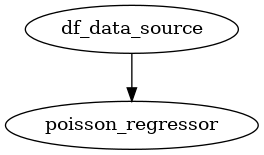

In [24]:
dtfcore.draw(dag)